# LangGraph Code Assistant

- Author: [Junseong Kim](https://www.linkedin.com/in/%EC%A4%80%EC%84%B1-%EA%B9%80-591b351b2/)
- Design: [Junseong Kim](https://www.linkedin.com/in/%EC%A4%80%EC%84%B1-%EA%B9%80-591b351b2/)
- Peer Review:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Cases/05-langgraph-plan-and-execute.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Cases/05-langgraph-plan-and-execute.ipynb)

## Overview

In this tutorial, we will build a simple code assistant workflow using **langgraph** and LangChain. We will demonstrate how to:

- Load and parse documentation from a URL using `RecursiveUrlLoader`.
- Create a Pydantic model (`code`) to structure code-generation responses.
- Use an LLM (Anthropic’s Claude) with a specialized prompt to generate code solutions.
- Integrate a custom parsing function to handle raw and structured outputs.
- Construct a state machine with `langgraph` to:
  - Generate code (`generate` node)
  - Check imports and execution (`check_code` node)
  - Reflect and retry if needed (`reflect` node)
- Visualize the workflow graph and finally display the generated code in a clean Markdown format.

By the end of this tutorial, you’ll be able to set up a multi-step code assistant pipeline that can iteratively generate, validate, and reflect on generated code.

![](./assets/11-langgraph-code-assistant.png)


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Building the Code Assistant Workflow](#building-the-code-assistant-workflow)
- [Loading and Preparing Documentation](#loading-and-preparing-documentation)
- [Defining a Pydantic Model for Code](#defining-a-pydantic-model-for-code)
- [Setting Up the Prompt and LLM Chain](#setting-up-the-prompt-and-llm-chain)
- [Parsing the LLM Output](#parsing-the-llm-output)
- [Constructing the State Machine](#Constructing-the-State-Machine)
- [Final Invocation and Display](#final-invocation-and-display)

### References

- [Langgraph](https://www.langchain.com/langgraph)
- [LangChain Anthropic Integration](https://python.langchain.com/docs/integrations/llms/anthropic)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain_anthropic",
        "langchain_community",
        "langgraph",
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "ANTHROPIC_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "11-LangGraph-Code-Assistant",
        }
    )

## Building the Code Assistant Workflow

Below, we will build a code assistant workflow using **langgraph**. This workflow can:

1. **Load** documentation with a custom loader.
2. **Use** a large language model (Anthropic’s Claude) with a structured output format.
3. **Check** generated code for errors and prompt for a retry if needed.
4. **Reflect** on errors and regenerate code.

We will demonstrate each step with a combination of Markdown explanations and code cells.


## Loading and Preparing Documentation

We use the `RecursiveUrlLoader` (from `langchain_community`) to fetch and parse documentation. We’ll store the documents in `docs`, sort them, and then concatenate the page content into a single string for use in our prompt.


In [1]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# LCEL docs
url = "https://python.langchain.com/v0.2/docs/tutorials/rag/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Sort the list based on the URLs and get the text
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

## Defining a Pydantic Model for Code

We define a Pydantic model named `code` to capture structured outputs for code generation. This model enforces a specific schema with fields for `prefix`, `imports`, and `code`.


In [2]:
from pydantic import BaseModel, Field


# Data model


class code(BaseModel):
    """Schema for code solutions to questions about LCEL."""

    prefix: str = Field(description="Description of the problem and approach")

    imports: str = Field(description="Code block import statements")

    code: str = Field(description="Code block not including import statements")

## Setting Up the Prompt and LLM Chain

We construct a prompt that instructs the LLM (Anthropic’s Claude) to produce answers in our specified `code` format.


In [5]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

# Prompt to enforce tool use
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """<instructions> You are a coding assistant with expertise in LCEL, LangChain expression language. \n 
    Here is the LCEL documentation:  \n ------- \n  {context} \n ------- \n Answer the user  question based on the \n 
    above provided documentation. Ensure any code you provide can be executed with all required imports and variables \n
    defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block. \n
    Invoke the code tool to structure the output correctly. </instructions> \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# LLM
expt_llm = "claude-3-opus-20240229"
llm = ChatAnthropic(
    model=expt_llm,
    default_headers={"anthropic-beta": "tools-2024-04-04"},
)

Next, we wrap this language model with `with_structured_output` to ensure it returns data that can be parsed into our `code` Pydantic model:


In [6]:
structured_llm_claude = llm.with_structured_output(code, include_raw=True)

Finally, we define a function `parse_output` to extract the parsed solution from the LLM’s raw response, and then we combine everything into a single chain:


In [7]:
def parse_output(solution):
    """When we add 'include_raw=True' to structured output,
    it will return a dict w 'raw', 'parsed', 'parsing_error'."""

    return solution["parsed"]


code_gen_chain = code_gen_prompt_claude | structured_llm_claude | parse_output

## Parsing the LLM Output

We run a quick test by asking a sample question. The chain returns a structured `code` object with `prefix`, `imports`, and `code`.


In [8]:
# Test
question = "How do I build a RAG chain in LCEL?"
solution = code_gen_chain.invoke(
    {"context": concatenated_content, "messages": [("user", question)]}
)
solution

code(prefix='Here is how you can build a RAG (Retrieval Augmented Generation) chain in LCEL (LangChain Expression Language):', imports='from langchain_chroma import Chroma\nfrom langchain_openai import OpenAIEmbeddings\nfrom langchain_text_splitters import RecursiveCharacterTextSplitter\nfrom langchain import hub\nfrom langchain_core.output_parsers import StrOutputParser\nfrom langchain_core.runnables import RunnablePassthrough', code='text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)\nsplits = text_splitter.split_documents(docs)\n\nvectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())\n\nretriever = vectorstore.as_retriever()\nprompt = hub.pull("rlm/rag-prompt")\n\ndef format_docs(docs):\n    return "\\\\n\\\\n".join(doc.page_content for doc in docs)\n\nrag_chain = (\n    {"context": retriever | format_docs, "question": RunnablePassthrough()}\n    | prompt\n    | llm \n    | StrOutputParser()\n)')

## Constructing the State Machine

To handle multiple steps—generating code, checking it, and reflecting on errors—we can use a **langgraph** state machine.

First, we create a `TypedDict` called `GraphState` to store our pipeline’s state. We also define some global parameters:


In [9]:
from typing import List
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: List
    generation: str
    iterations: int

**1. Define the Nodes**

We have three main nodes in our state machine:

1. **generate**: Calls the LLM chain to produce code.
2. **code_check**: Attempts to `exec` the code. If it fails, we raise a flag.
3. **reflect**: Optionally reflect on errors and refine the solution.

We’ll define each one in its own cell for clarity.


**1.1 generate Node**

This node invokes the `code_gen_chain` to generate a new code solution. If there was a previous error, it adds a user message instructing the LLM to try again.


In [10]:
### Parameter

# Max tries
max_iterations = 5
# Reflect
flag = "reflect"
# flag = "do not reflect"

### Nodes


def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # We have been routed back to generation with an error
    if error == "yes":
        messages += [
            (
                "user",
                "Now, try again. Invoke the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]

    # Solution
    code_solution = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [
        (
            "assistant",
            f"{code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

**1.2 code_check Node**

This node checks the generated code by attempting to `exec` the imports and the main code block. If anything fails, it appends an error message and flags the state.


In [11]:
def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        print(e)
        error_message = [("user", f"Your solution failed the import test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        exec(imports + "\n" + code)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

**1.3 reflect Node**

If code checking fails, we can optionally reflect on errors and refine the solution. This node prompts the LLM for additional insights and attaches them to the current message list.


In [12]:
def reflect(state: GraphState):
    """
    Reflect on errors

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION (reflect)---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    code_solution = state["generation"]

    # Prompt reflection

    # Add reflection
    reflections = code_gen_chain.invoke(
        {"context": concatenated_content, "messages": messages}
    )
    messages += [("assistant", f"Here are reflections on the error: {reflections}")]
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

**2. Defining the Workflow**

Next, we tie these nodes together with **langgraph** to create our state machine. We also define a helper function `decide_to_finish` that determines whether we have encountered an error or exceeded our iteration limit.


In [14]:
from langgraph.graph import END, StateGraph, START


def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        if flag == "reflect":
            return "reflect"
        else:
            return "generate"


# Build the state machine
workflow = StateGraph(GraphState)

workflow.add_node("generate", generate)
workflow.add_node("check_code", code_check)
workflow.add_node("reflect", reflect)

# Sequence:
# 1. START -> generate
# 2. generate -> check_code
# 3. check_code -> either "end" or "reflect" or "generate"
workflow.add_edge(START, "generate")
workflow.add_edge("generate", "check_code")
workflow.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "reflect": "reflect",
        "generate": "generate",
    },
)
workflow.add_edge("reflect", "generate")

app = workflow.compile()

**3. Visualizing the Workflow**

We can visualize the state machine using the `visualize_graph` function from `langchain_opentutorial.graphs`.


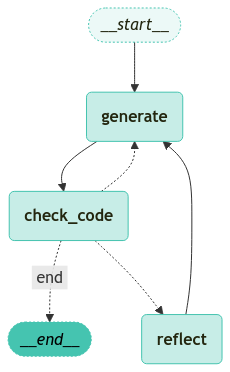

In [15]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(app)

## Final Invocation and Display

Finally, we pass a user question into our compiled state machine. The pipeline will:
1. Generate code.
2. Check it.
3. Reflect if there’s an error.
4. Repeat until success or until we reach our maximum number of attempts.


In [16]:
question = "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?"
solution = app.invoke({"messages": [("user", question)], "iterations": 0, "error": ""})
solution["generation"]

---GENERATING CODE SOLUTION---
---CHECKING CODE---
---NO CODE TEST FAILURES---
---DECISION: FINISH---


code(prefix='To pass a string directly through to a prompt, you can use the RunnablePassthrough class. This will take the input string and pass it through unchanged to be used in constructing the prompt input.', imports='from langchain_core.prompts import PromptTemplate\nfrom langchain_core.runnables import RunnablePassthrough\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.output_parsers import StrOutputParser', code='template = """Answer the following question.\n\nQuestion: {input}\n\nAnswer:"""\n\nprompt = PromptTemplate.from_template(template)\n\nllm = ChatOpenAI()\n\nchain = (\n    RunnablePassthrough()\n    | prompt \n    | llm\n    | StrOutputParser()\n)\n\nchain.invoke("What is the capital of France?")')

We define a helper function to display the resulting code in a Markdown cell:

In [17]:
from IPython.display import Markdown, display


def display_markdown_code(solution):
    """
    Render the final solution (Structured Output) as a Markdown code block.
    """

    md_text = f"""

**{solution.prefix}**


```python

# Imports

{solution.imports}


# Code

{solution.code}
"""

    display(Markdown(md_text))

The final output is displayed in Markdown, allowing you to immediately see the generated code solution

In [18]:
display_markdown_code(solution["generation"])



**To pass a string directly through to a prompt, you can use the RunnablePassthrough class. This will take the input string and pass it through unchanged to be used in constructing the prompt input.**


```python

# Imports

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


# Code

template = """Answer the following question.

Question: {input}

Answer:"""

prompt = PromptTemplate.from_template(template)

llm = ChatOpenAI()

chain = (
    RunnablePassthrough()
    | prompt 
    | llm
    | StrOutputParser()
)

chain.invoke("What is the capital of France?")
